In [1]:
%load_ext autoreload
%autoreload 2
import poisson_atac as patac
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

Global seed set to 0


In [2]:
sns.set_style("whitegrid")

fig_path = 'panels/Figure1'

In [3]:
data_path = 'data' # symbolic link to actual data directory

# Neurips dataset

In [ ]:
adata = patac.data.load_neurips(data_path=data_path, only_train=False, convert_counts = False)

In [10]:
adata

AnnData object with n_obs × n_vars = 62501 × 116490
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train', 'size_factor'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism', 'sample_pm_varnames'
    obsm: 'gene_activity', 'lsi_full', 'lsi_red', 'umap'
    layers: 'counts'

## Infer isolated label

In [7]:
pd.crosstab(adata.obs.cell_type, adata.obs.batch) # ID2-hi myeloid prog is the isolated label

batch,s1d1,s1d2,s1d3,s2d1,s2d4,s2d5,s3d10,s3d3,s3d6,s3d7,s4d1,s4d8,s4d9
cell_type,,,,,,,,,,,,,
B1 B,183,113,69,60,0,108,195,47,56,114,367,297,86
CD14+ Mono,830,636,220,1188,1015,1559,781,189,674,1450,921,399,0
CD16+ Mono,59,164,22,185,157,337,34,17,41,226,227,91,135
CD4+ T activated,744,644,349,395,354,440,204,247,102,187,557,612,133
CD4+ T naive,487,1151,478,234,184,145,291,52,98,92,354,267,113
CD8+ T,647,1466,932,157,203,665,343,427,110,386,692,3687,708
CD8+ T naive,0,0,180,0,0,0,211,0,0,326,0,0,203
cDC2,35,85,64,28,46,25,102,21,25,75,97,144,21
Erythroblast,714,125,338,428,1332,62,222,78,31,356,432,241,78


## Plot count distribution

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


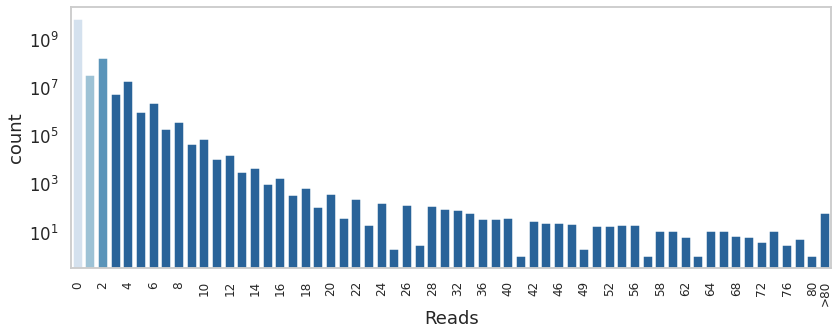

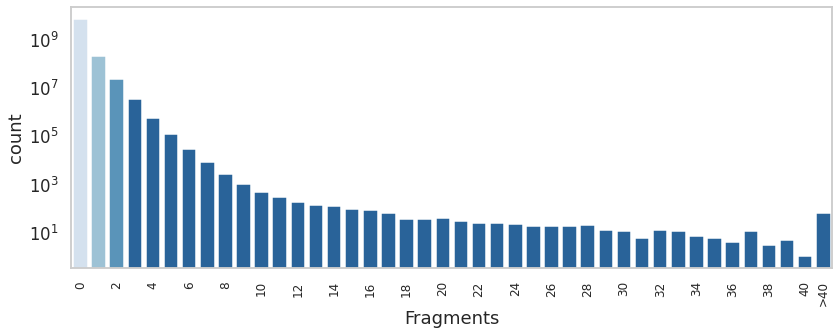

In [8]:
patac.pl.count_distribution(adata, layer="counts", figsize=(12, 5), limit=80, save_path=fig_path, save_prefix="neurips")

## Plot proportions

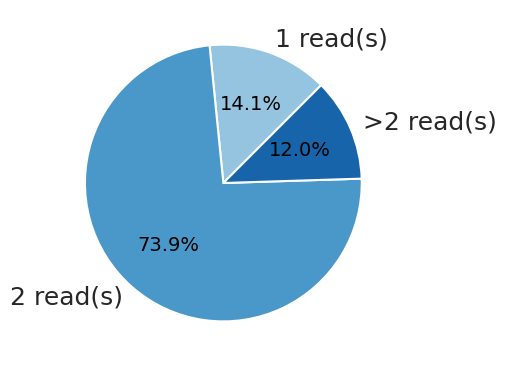

In [11]:
patac.pl.proportions(adata, lower_limit=1, upper_limit=2, layer="counts", save_path=fig_path, save_prefix="neurips")

## Plot mean-variance relationship

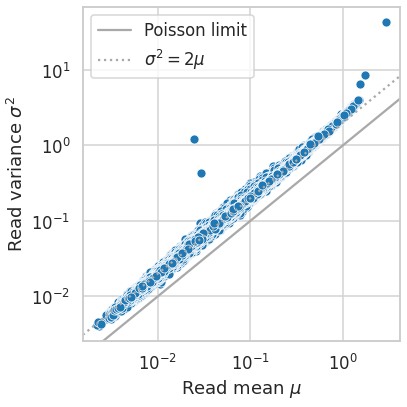

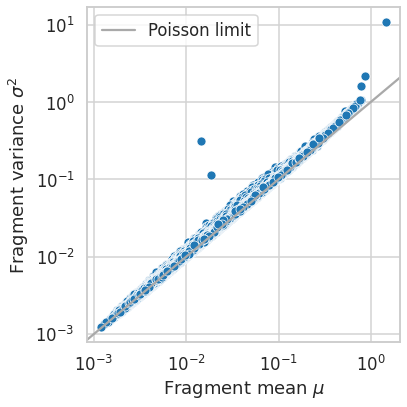

In [9]:
patac.pl.mean_variance(adata, layer="counts", figsize=(6,6), save_path=fig_path, save_prefix="neurips")

# Hematopoeisis dataset (Satpathy et al.)

In [ ]:
adata = patac.data.load_hematopoiesis(data_path=data_path, convert_counts = False)

In [5]:
adata

AnnData object with n_obs × n_vars = 63882 × 134104
    obs: 'UMAP1', 'UMAP2', 'Clusters', 'Group', 'depth', 'FRIP', 'Internal_Name', 'Group_Barcode', 'cell_type'
    var: 'Feature', 'n_cells'
    obsm: 'X_umap'
    layers: 'counts'

## Infer isolated label

In [7]:
(pd.crosstab(adata.obs.cell_type, adata.obs.Group) > 0).sum(axis=1) # Pre-B is isolated label

cell_type
Basophil                 13
CLP                       5
CMP-BMP                  12
Central-memory-CD8-T     16
Effector-memory-CD8-T    15
GMP                       6
Gamma delta T            12
HSC                      16
Immature-NK              12
LMPP                     17
MDP                      12
MEP                      15
Mature-NK1               11
Mature-NK2                8
Memory-B                  9
Memory-CD4-T             16
Monocyte-1               12
Monocyte-2               14
Naive-B                   9
Naive-CD4-T1             13
Naive-CD4-T2             11
Naive-CD8-T1              7
Naive-CD8-T2             12
Naive-CD8-T3             15
Naive-Treg               10
Plasma-cell              11
Pre-B                     4
Pro-B                     5
Treg                     14
cDC                      13
pDC                      11
dtype: int64

## Plot count distribution

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


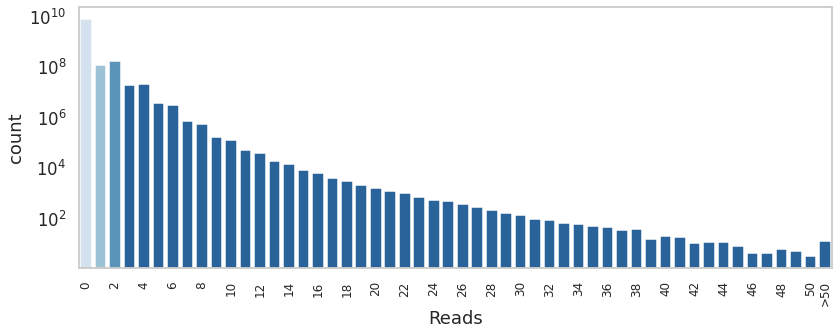

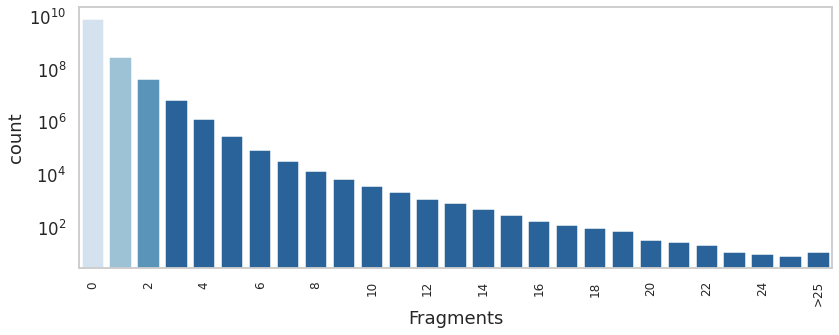

In [16]:
patac.pl.count_distribution(adata, layer="counts", figsize = (12, 5), limit = 50, save_path=fig_path, save_prefix="hematopoiesis")

## Plot proportions

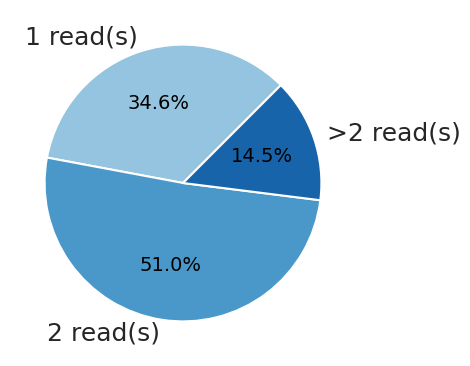

In [13]:
patac.pl.proportions(adata, lower_limit=1, upper_limit=2, layer="counts", save_path=fig_path, save_prefix="hematopoiesis")

## Plot mean-variance relationship

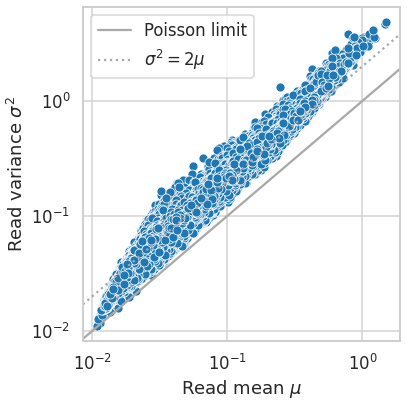

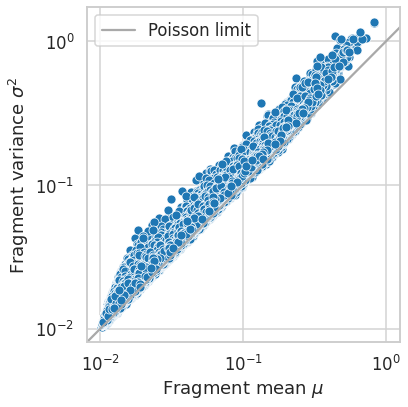

In [12]:
patac.pl.mean_variance(adata, layer="counts", figsize=(6,6), save_path=fig_path, save_prefix="hematopoiesis")